In [2]:
# Load dataset

import zipfile
import os
import pandas as pd

#with zipfile.ZipFile('ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
#    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

data.head()

The number of samples: 827
The number of columns: 9001


,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749,label
0,47.685046,48.416904,37.371002,61.604757,58.732738,213.067966,120.890451,40.100639,19.106303,6.043738,...,0.078753,0.379885,0.182930,0.231552,0.222432,0.154919,0.158616,0.269249,0.112248,0
1,152.726718,297.353726,111.168880,25.419423,14.636085,24.609688,49.533842,253.651571,483.852043,167.617409,...,0.804160,0.809705,0.830032,0.774368,0.798178,0.853519,0.827946,0.859936,0.742673,1
2,1.601260,3.882169,22.978997,21.673040,8.919484,18.329286,27.710604,23.350084,37.896254,8.331180,...,0.156080,0.102070,0.168276,0.120385,0.064254,0.077670,0.059857,0.098506,0.098288,0
3,1.388947,3.052483,3.084103,4.627886,10.016196,15.020347,139.823127,20.149108,10.393109,9.241921,...,0.238274,0.096733,0.030739,0.170214,0.052079,0.179360,0.226222,0.092000,0.192559,0
4,3.625561,3.728466,6.205367,17.722897,5.699401,9.024836,15.782812,33.336480,55.257804,19.139128,...,0.056914,0.059116,0.050098,0.152588,0.129712,0.047342,0.058446,0.141610,0.129477,0


In [3]:
# Preprocess data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming the first columns are features, and the last column is the label
X = data.iloc[:, :-1].values  # Features (ECG frequency data)
y = data.iloc[:, -1].values   # Labels (0 = Normal, 1 = Abnormal)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
# Perform feature selection
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Select Features using Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_feature_indices = np.argsort(mi_scores)[-2100:]  # Select top 2100 features
X_train_mi = X_train_scaled[:, mi_feature_indices]
X_val_mi = X_val_scaled[:, mi_feature_indices]

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       109
           1       0.70      0.29      0.41        24

    accuracy                           0.85       133
   macro avg       0.78      0.63      0.66       133
weighted avg       0.83      0.85      0.82       133

Optimized Accuracy (Mutual Information Feature Selection): 0.8496


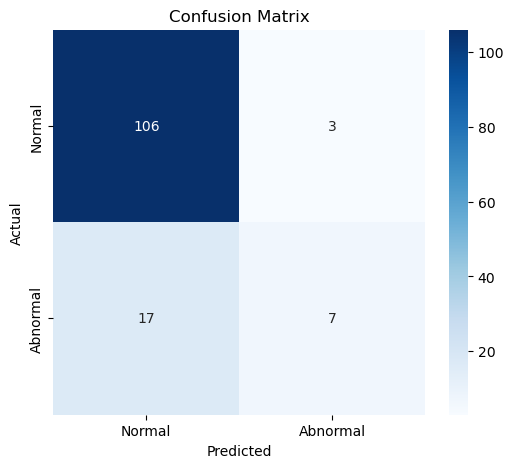

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples at a leaf node
    'bootstrap': [True, False]        # Bootstrap sampling
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_mi, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters on selected features
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_mi, y_train)
y_pred_best = best_rf.predict(X_val_mi)

# Compute Accuracy, classification report & Confusion Matrix
accuracy_mi = accuracy_score(y_val, y_pred_best)
print(classification_report(y_val, y_pred_best))
cm_mi = confusion_matrix(y_val, y_pred_best)

print(f"Optimized Accuracy (Mutual Information Feature Selection): {accuracy_mi:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mi, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

c:\Users\groot\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0       0.84      0.34      0.48       109
           1       0.19      0.71      0.30        24

    accuracy                           0.41       133
   macro avg       0.52      0.52      0.39       133
weighted avg       0.72      0.41      0.45       133

Accuracy of QDA): 0.4060


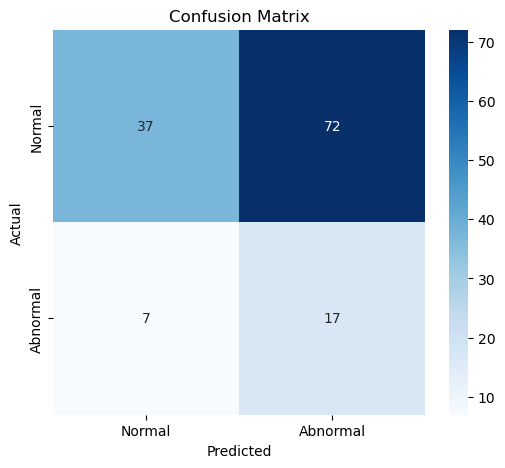

In [8]:
# Perform Quadratic Discriminant Analysis (QDA)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize QDA model
qda = QuadraticDiscriminantAnalysis(priors=[0.5, 0.5], reg_param=0.1)
qda.fit(X_train_mi, y_train)

# Make predictions on the validation set
y_pred_qda = qda.predict(X_val_mi)

# Compute Accuracy, classification report & Confusion Matrix
accuracy_qda = accuracy_score(y_val, y_pred_qda)
print(classification_report(y_val, y_pred_qda))
cm_qda = confusion_matrix(y_val, y_pred_qda)

print(f"Accuracy of QDA): {accuracy_qda:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_qda, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       109
           1       0.50      0.38      0.43        24

    accuracy                           0.82       133
   macro avg       0.68      0.65      0.66       133
weighted avg       0.80      0.82      0.81       133

Accuracy of Gaussian Naive Bayes: 0.8195


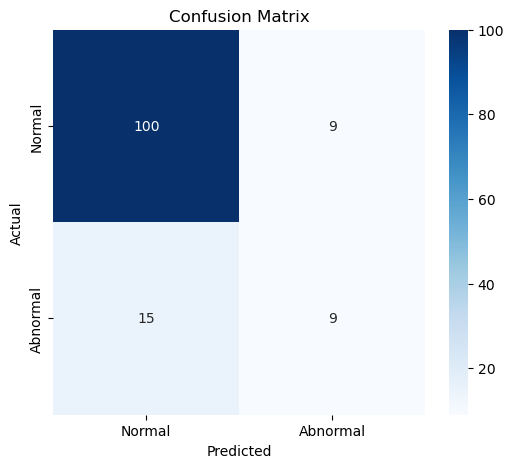

In [9]:
# Perform Gaussian Naive Bayes

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Gaussian Naive Bayes model
gnb = GaussianNB(priors=[0.5, 0.5])
gnb.fit(X_train_mi, y_train)

# Make predictions on the validation set
y_pred_gnb = gnb.predict(X_val_mi)

# Compute Accuracy, classification report & Confusion Matrix
accuracy_gnb = accuracy_score(y_val, y_pred_gnb)
print(classification_report(y_val, y_pred_gnb))
cm_gnb = confusion_matrix(y_val, y_pred_gnb)

print(f"Accuracy of Gaussian Naive Bayes: {accuracy_gnb:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
